In [1]:
import pandas as pd
import numpy as np

from src.data_handling import (load_csv_data, 
                               filter_data_by_year_range, 
                               append_string_to_elements, 
                               save_to_csv)

from matplotlib import pyplot as plt

from src.vol_forecasting import GARCHVolForecast, StochasticVolForecast
from arch import arch_model

In [2]:
DATA_PATH = "DATA/processed/df.csv"

df = load_csv_data(DATA_PATH)
df.head()

,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,...,VIX_Open,VIX_High,VIX_Low,VIX_Close,VIX_Adj Close,IRX_Open,IRX_High,IRX_Low,IRX_Close,IRX_Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.531765,212818400.0,15.6290,15.7375,15.3480,15.4260,...,17.760000,20.139999,17.049999,17.790001,17.790001,0.030,0.030,0.015,0.015,0.015
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.840672,257142000.0,15.3505,15.4190,15.0425,15.1095,...,19.190001,21.290001,19.190001,19.920000,19.920000,0.008,0.018,0.003,0.003,0.003
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.842909,263188400.0,15.1120,15.1500,14.6190,14.7645,...,20.330000,22.900000,19.520000,21.120001,21.120001,0.023,0.023,0.018,0.020,0.020
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.177242,160423600.0,14.8750,15.0640,14.7665,14.9210,...,20.150000,20.719999,19.040001,19.309999,19.309999,0.023,0.025,0.020,0.020,0.020
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.106180,237458000.0,15.0160,15.1570,14.8055,15.0230,...,17.930000,18.090000,16.990000,17.010000,17.010000,0.020,0.020,0.015,0.018,0.018


In [3]:
from src.stoch_modelling import CorrelatedJDMSimulator

corrJDMsim = CorrelatedJDMSimulator()
# Estimate parameters
corrJDMsim.estimate_parameters(df[['AAPL_Close', 'AMZN_Close', 'MSFT_Close']].iloc[1880:1900].values)

# Setting initial prices
corrJDMsim.initial_prices = df[['AAPL_Close', 'AMZN_Close', 'MSFT_Close']].iloc[1900].values

# Generating simulation 
simulated_prices = [corrJDMsim.simulate(7) for _ in range(10_000)]

simulated_prices = np.array(simulated_prices)

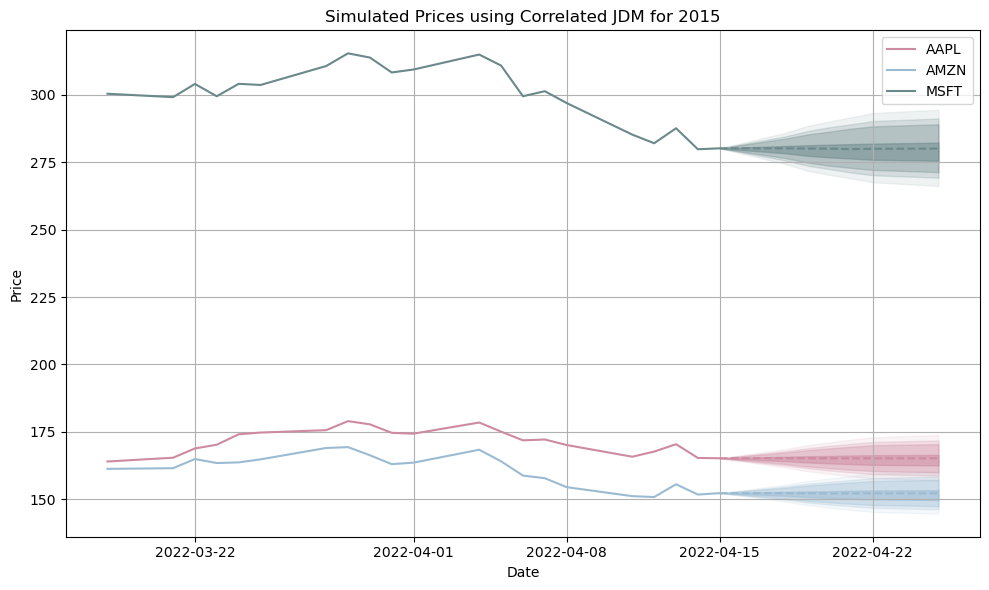

In [5]:
# Plotting initial price history
plt.figure(figsize=(10, 6))
colours = ['#CD8AA0', '#9BBBD2', '#6B888A']
for i, asset in enumerate(['AAPL', 'AMZN', 'MSFT']):
    plt.plot(df.index[1880:1901], df[f"{asset}_Close"].iloc[1880:1901], label=asset, color=colours[i])

# Convert simulated prices to a 3D numpy array for easier manipulation
simulated_prices_array = np.array(simulated_prices)

# Define percentiles for the 5 layers
percentiles = [(5, 95), (10, 90), (15, 85),  (30, 60)]
alphas = [0.1, 0.2, 0.3, 0.5]

# Calculate and plot the layers
for (p_low, p_high), alpha in zip(percentiles, alphas):
    lower_bound = np.percentile(simulated_prices_array, p_low, axis=0)
    upper_bound = np.percentile(simulated_prices_array, p_high, axis=0)
    for i, asset in enumerate(['AAPL', 'AMZN', 'MSFT']):
        plt.fill_between(df.index[1900:1907], lower_bound[:, i], upper_bound[:, i], color=colours[i], alpha=alpha)

# Plot the median
median = np.median(simulated_prices_array, axis=0)
for i, asset in enumerate(['AAPL', 'AMZN', 'MSFT']):
    plt.plot(df.index[1900:1907], median[:, i], color=colours[i], linestyle='--')

plt.title("Simulated Prices using Correlated JDM for 2015")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

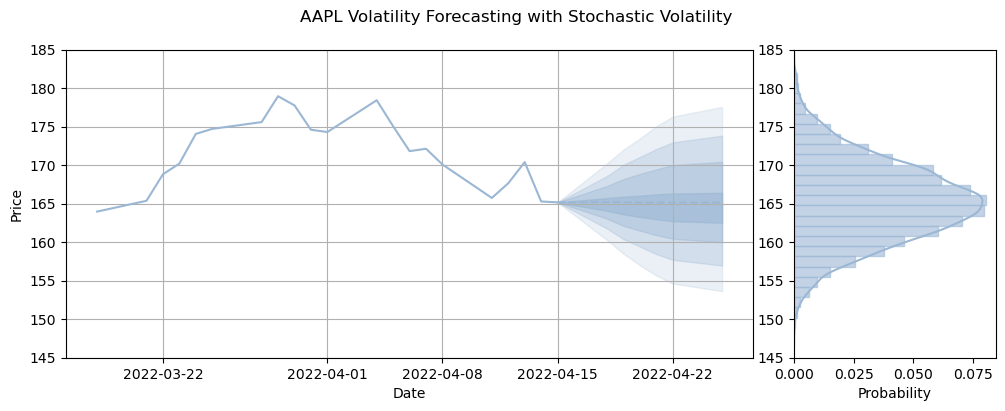

In [7]:
from scipy.stats import gaussian_kde
from scipy import stats
colours[0] = '#9BB7D4'
asset = 'AAPL'


gridsize = (1, 4)
fig = plt.figure(figsize=(12, 4))

# AAPL
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=3, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (0, 3))
fig.suptitle(f"{asset} Volatility Forecasting with Stochastic Volatility")

# plotting simulations
ax1.plot(df.index[1880:1901], df[f"{asset}_Close"].iloc[1880:1901], label=asset, color=colours[0])
ax1.plot(df.index[1900:1907], median[:, 0], color=colours[0], linestyle='--')

simulated_prices_array = np.array(simulated_prices)
# Define percentiles for the 5 layers
percentiles = [(1, 99), (5, 95), (15, 85),  (30, 60)]
alphas = [0.2, 0.3, 0.4, 0.6]

# Calculate and plot the layers
for (p_low, p_high), alpha in zip(percentiles, alphas):
    lower_bound = np.percentile(simulated_prices_array, p_low, axis=0)
    upper_bound = np.percentile(simulated_prices_array, p_high, axis=0)
    ax1.fill_between(df.index[1900:1907], lower_bound[:, 0], upper_bound[:, 0], color=colours[0], alpha=alpha)

ax1.set_ylim(145,185)


kde = stats.gaussian_kde(simulated_prices_array[:, -1, 0])
ax2.hist(simulated_prices_array[:, -1, 0], density=True, bins=30, orientation="horizontal",edgecolor=colours[0], color = colours[0], alpha=0.6)

kde = gaussian_kde(simulated_prices_array[:, -1, 0])
y_vals = np.linspace(min(simulated_prices_array[:, -1, 0]), max(simulated_prices_array[:, -1, 0]), 1000)
kde_vals = kde(y_vals)
ax2.plot(kde_vals, y_vals, color=colours[0], label='KDE')

ax2.set_ylim(145,185)

ax1.set_xlabel("Date")
ax2.set_xlabel("Probability")
ax1.set_ylabel("Price")
ax1.grid(True)

plt.savefig(f'{asset}.png', dpi=300)


In [38]:
def plot_forecast(data_list, assets, colours):

    num_plots = len(data_list)

    gridsize = (num_plots, 4)
    fig = plt.figure(figsize=(12, 4 * num_plots))
    
    # Define percentiles for the 5 layers
    percentiles = [(1, 99), (5, 95), (15, 85),  (30, 60)]
    alphas = [0.2, 0.3, 0.4, 0.6]

    for i in range(num_plots):
        # Identifying variables:
        hist_price = data_list[i][0]
        sim_price = data_list[i][1]
        asset = assets[i]
        colour = colours[i]
        # Setting graph up
        axl = plt.subplot2grid(gridsize, (i, 0), colspan=3, rowspan=1)
        axr = plt.subplot2grid(gridsize, (i, 3))
        fig.suptitle(f"{asset} Volatility Forecasting with Stochastic Volatility")

        # plotting simulations
        axl.plot(hist_price.index, hist_price.values, label=asset, color=colour)
        axl.plot(hist_price.index, hist_price.values, color=colour, linestyle='--')

        # Calculate and plot the layers
        for (p_low, p_high), alpha in zip(percentiles, alphas):
            lower_bound = np.percentile(sim_price, p_low, axis=0)
            upper_bound = np.percentile(sim_price, p_high, axis=0)
            print(lower_bound[:, 0])
            print(upper_bound[:, 0])
            axl.fill_between(hist_price.index[-7:], lower_bound[:, 0], upper_bound[:, 0], color=colour, alpha=alpha)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

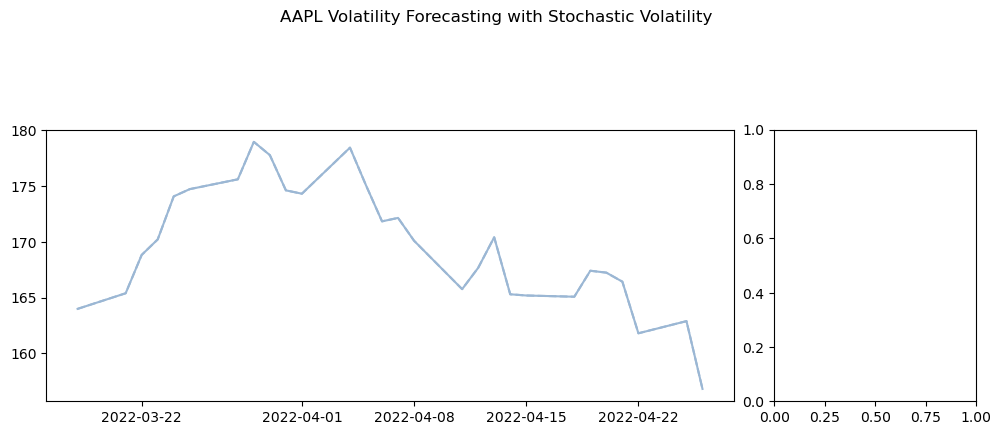

In [39]:
data_list = [(df['AAPL_Close'].iloc[1880:1908], simulated_prices[:, :, 0]),
             (df['AMZN_Close'].iloc[1880:1908], simulated_prices[:, :, 1]),
             (df['MSFT_Close'].iloc[1880:1908], simulated_prices[:, :, 2]),]

assets = ['AAPL', 'AMZN', 'MSFT']

colours = ['#9BB7D4', '#BF1932', '#009473']

plot_forecast(data_list, assets, colours)

In [33]:
simulated_prices[:, :, 2]

array([[280.174988  , 283.68032935, 290.81890322, ..., 291.57926656,
        287.30640665, 286.78106353],
       [280.174988  , 281.85195673, 284.3778031 , ..., 285.84930867,
        281.11553895, 286.17345746],
       [280.174988  , 271.1630542 , 267.89955148, ..., 274.32602007,
        268.50297896, 272.34568874],
       ...,
       [280.174988  , 280.61722088, 278.10159946, ..., 272.68252766,
        269.55373273, 272.85796935],
       [280.174988  , 279.82138788, 280.13808161, ..., 282.18212066,
        283.30479263, 284.88745147],
       [280.174988  , 285.30890843, 290.62463602, ..., 294.0041624 ,
        289.49894818, 285.2938871 ]])